In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python==4.5.5.64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [ ]:
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, numpy, numpy, numpy
Required-by: dopamine-rl, imgaug


In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset', 'Personal_Dataset', 'Models', 'Code', 'test_functions.ipynb']


In [ ]:
#code taken from lecture 6
#path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset','CV2024_CW_Dataset.zip' )

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

In [ ]:
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from skimage import data, exposure

%matplotlib inline

In [ ]:
# Function to load images from the 'images' directory and their labels from text files in the 'labels' directory
def import_images_and_labels(root_path):
    images = []
    labels = []

    # Define paths to images and labels directories
    images_path = os.path.join(root_path, 'images')
    labels_path = os.path.join(root_path, 'labels')

    # Get sorted list of image files
    image_files = sorted([f for f in os.listdir(images_path)])

    for image_file in image_files:
        # Read the image
        image_path = os.path.join(images_path, image_file)
        images.append(io.imread(image_path))

        # Read the corresponding label
        label_file = image_file.replace('.jpeg', '.txt')
        label_path = os.path.join(labels_path, label_file)
        with open(label_path, 'r') as file:
            label = file.read().strip()
            labels.append(int(label))

    return images, labels

In [ ]:
#Load the images and the corresponding labels in X and y
X, y = import_images_and_labels('train')


In [ ]:
#Let's print the shape of the first 5 images
for i in range (5):
  print(X[i].shape)
for i in range (5):
  print(y[i])


(37, 30, 3)
(44, 41, 3)
(51, 35, 3)
(35, 33, 3)
(35, 37, 3)
0
1
0
1
1


Images have different sizes. So it would be a good practice to resize them all to a specified size. Let's first see the distribution of the sizes in a scatter plot

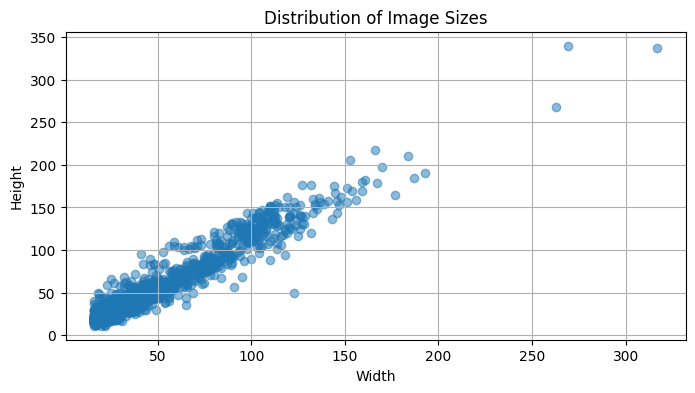

In [ ]:

widths = [img.shape[1] for img in X]  # Width is at index 1
heights = [img.shape[0] for img in X]  # Height is at index 0

# Now, let's plot the sizes as a scatter plot
plt.figure(figsize=(8, 4))
plt.scatter(widths, heights, alpha=0.5)
plt.title('Distribution of Image Sizes')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True)

plt.show()

In [ ]:
print(Counter(y))
#This prints how many occurrences of images we have for each label. We can clearly see that there are class imbalances

Counter({1: 1940, 0: 376, 2: 78})


In [ ]:
#Function to resize the images
def resize_images(X, target_size=(128, 150)):
    resized_images = []
    for img_array in X:
        resized_img_array = cv2.resize(img_array, target_size, interpolation=cv2.INTER_AREA)
        resized_images.append(resized_img_array)
    return resized_images

#Resizing all the images
X_resized = resize_images(X)

#print the shape of the first 3 images
for img_array in X_resized[:3]:
    print(img_array.shape)


(150, 128, 3)
(150, 128, 3)
(150, 128, 3)


In [ ]:
#Making the images all greyscale because we don't need much information about the color for this specific task. And the computaation is much faster with greyscale images.
from skimage import io, color, filters
X_gray = [color.rgb2gray(img) for img in X_resized]

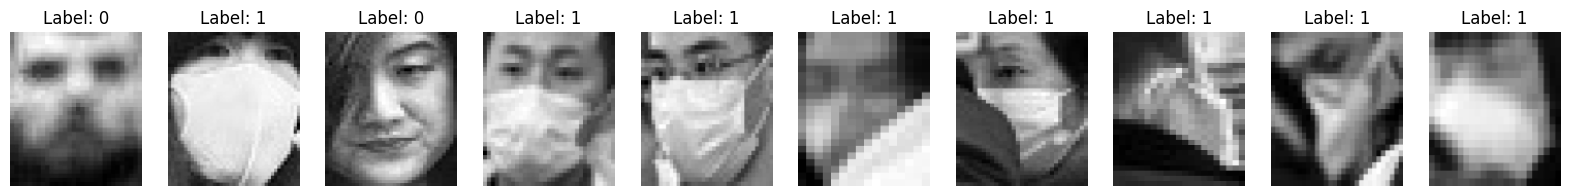

In [ ]:
# plotting grayscale images
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(ax):
    img = X_gray[i]
    # Show image
    ax.imshow(img, cmap='gray')
    # Show label
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.show()

In [ ]:
# Let's try to apply a histogram equalization to improve the contrast in images
X_hist_eq = [exposure.equalize_hist(img) for img in X_gray]

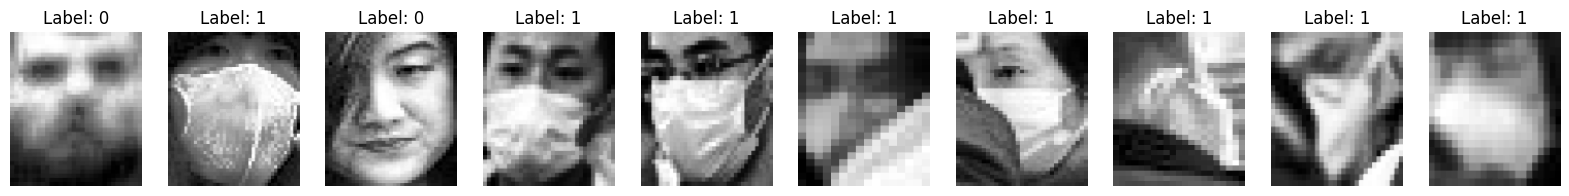

In [ ]:
#Images with Histogram Equalization
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(ax):
    img = X_hist_eq[i]
    # Show image
    ax.imshow(img, cmap='gray')
    # Show label
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.show()

In [ ]:
#Let's try to apply also a sharpening filter to enhance the edges
X_sharp = [filters.unsharp_mask(img, radius=1, amount=2) for img in X_hist_eq]

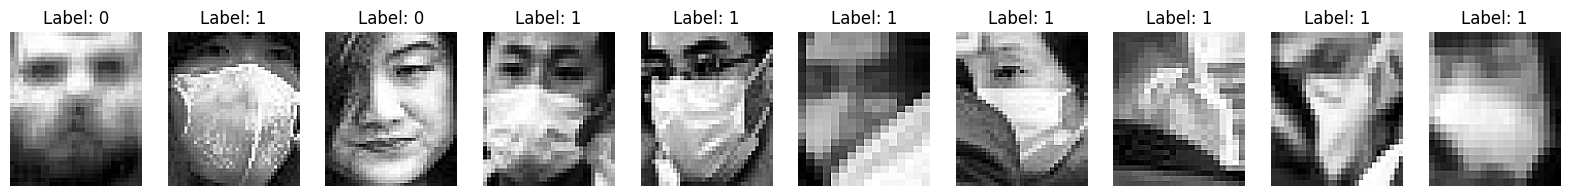

In [ ]:
#Images with a sharpened filter
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(ax):
    img = X_sharp[i]
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.show()

In [ ]:
#Let's now extract the HOG feature descriptor
#code taken and adapted from lecture 5
from skimage.feature import hog
def extract_hog_features(image_list):
    hog_features_list = []
    hog_images_list = []
    for image in image_list:
        features, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2),
                                  visualize=True, multichannel=False, feature_vector=True) # False multichannel because my images are greyscale
        hog_features_list.append(features)
        hog_images_list.append(hog_image)
    return hog_features_list, hog_images_list



In [ ]:
# Extract HOG descriptors and images
hog_des, hog_images = extract_hog_features(X_sharp)

<ipython-input-29-00ec59f4a75b>:7: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),


In [ ]:
# Print the shape of each HOG descriptor
for i, hog_feat in enumerate(hog_des[:3]):
    print(f'HOG Descriptor {i} shape:', hog_feat.shape)

#The HOG descriptor have shape 9180

HOG Descriptor 0 shape: (8160,)
HOG Descriptor 1 shape: (8160,)
HOG Descriptor 2 shape: (8160,)


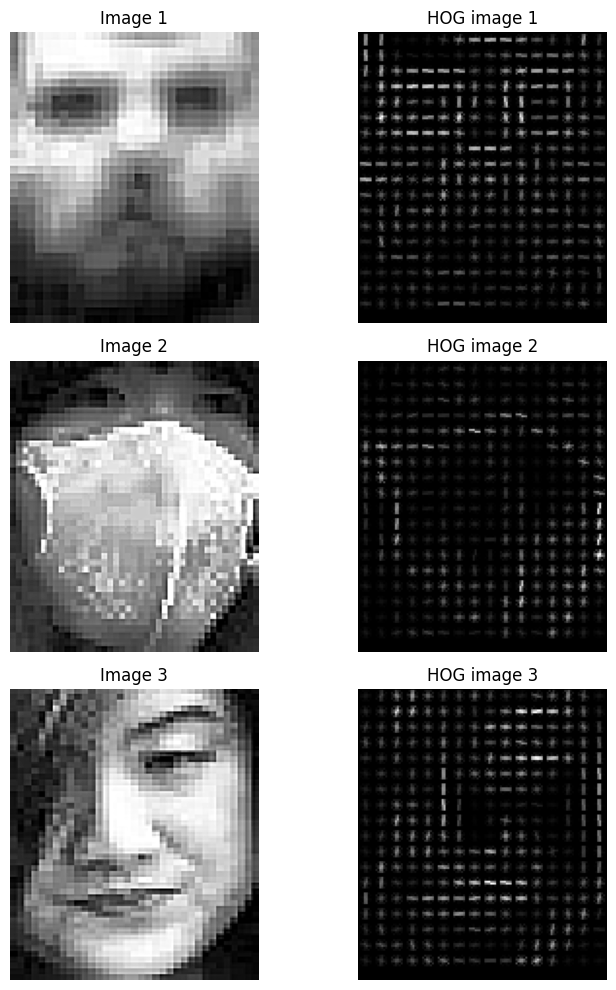

In [ ]:

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(8, 10)) # 3 rows for each image and its HOG, 2 columns for the two types of images

for i in range(3):
    # Show original image
    axes[i, 0].axis('off')
    axes[i, 0].imshow(X_sharp[i], cmap='gray')
    axes[i, 0].set_title(f'Image {i+1}')

    # Rescale histogram for better display of the HOG image
    hog_image_rescaled = exposure.rescale_intensity(hog_images[i], in_range=(0, 10))

    # Show HOG image
    axes[i, 1].axis('off')
    axes[i, 1].imshow(hog_image_rescaled, cmap='gray')
    axes[i, 1].set_title(f'HOG image {i+1}')

fig.tight_layout()
plt.show()

In [ ]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(hog_des, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Initialize the SVM classifier
classifier = svm.SVC(gamma=0.001)   #when gamma is pecified, the kernel model is 'rbf'
# Train the classifier
classifier.fit(X_train, y_train)

SVC(gamma=0.001)

In [ ]:
# Predict on the validation set
y_pred = classifier.predict(X_val)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_val, y_pred)}\n""")

Classification report for classifier SVC(gamma=0.001):
                    precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.84      1.00      0.91       401
           2       0.00      0.00      0.00        16

    accuracy                           0.84       479
   macro avg       0.28      0.33      0.30       479
weighted avg       0.70      0.84      0.76       479




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classification report shows that the classifier with gamma=0.001 is performing well only for the class labeled 1, which corresponds to the 'mask worn correctly' category. The model did not make any prediction for instances of class 0 (No mask) and class 2 (Mask worn incorrectly). This is indicated by the precision and recall scores of 0.00 for these classes. This might have happened because there are class imbalances and the classifier might have been biased towards the majority class. To try to filx this, I'll now make another SVM model with these hyperparameters classifier = svm.SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42) where class_weight='balanced' parameter will automatically adjust weights inversely proportional to class frequencies in the input data


In [ ]:
# Initialize the SVM classifier
classifier = svm.SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
# Train the classifier
classifier.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear', random_state=42)

In [ ]:
# Predict on the validation set
y_pred = classifier.predict(X_val)

In [ ]:
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_val, y_pred)}\n""")

Classification report for classifier SVC(class_weight='balanced', kernel='linear', random_state=42):
                    precision    recall  f1-score   support

           0       0.51      0.53      0.52        62
           1       0.90      0.93      0.91       401
           2       1.00      0.06      0.12        16

    accuracy                           0.85       479
   macro avg       0.80      0.51      0.52       479
weighted avg       0.85      0.85      0.84       479




This model is slightly better than the previous one as it predicts few instances of the classes 0 and 2.

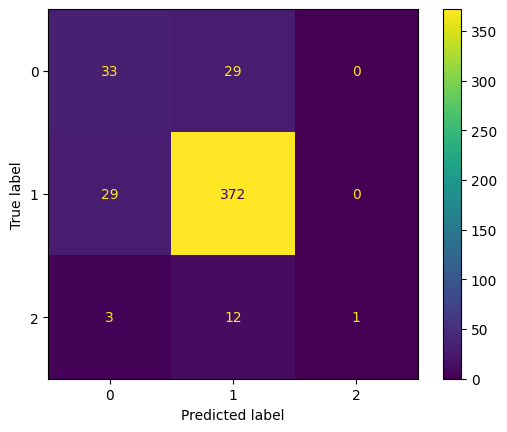

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

In [ ]:
#Let's now save the classifier
from joblib import dump

path_to_save =os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'svm_classifier.joblib')
dump(classifier, path_to_save)

['drive/My Drive/Colab Notebooks/CW_Folder_UG/Models/svm_classifier.joblib']

In [ ]:
#Let's load the classifier
from joblib import load
path_classifier = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'svm_classifier.joblib')
classifier = load(path_classifier)

In [ ]:
#It's time to test on the test set of the data. First I need to load the images and labels and preprocess the images.
X_test, y_test = import_images_and_labels('test')
def preprocess_images(images, target_size=(128, 150)):
    preprocessed_images = []

    for img in images:
        # Resize the image
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

        # Convert the resized image to grayscale
        img_gray = color.rgb2gray(img_resized)

        # Apply histogram equalization
        img_hist_eq = exposure.equalize_hist(img_gray)

        # Apply sharpening filter
        img_sharp = filters.unsharp_mask(img_hist_eq, radius=1, amount=2)

        preprocessed_images.append(img_sharp)

    return preprocessed_images

X_preprocessed = preprocess_images(X_test)

In [ ]:
# Print the shape of the first 3 preprocessed images to verify
for img in X_preprocessed[:3]:
    print(np.array(img).shape)

(150, 128)
(150, 128)
(150, 128)


In [ ]:
X_test_hog = [hog(image, orientations=8, pixels_per_cell=(8, 8),
              cells_per_block=(2, 2),
              visualize=False, multichannel=False, feature_vector=True)
              for image in X_preprocessed]

<ipython-input-87-dfabbb4452e9>:1: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  X_test_hog = [hog(image, orientations=8, pixels_per_cell=(8, 8),


In [ ]:
#Make predictions on the test set
y_pred = classifier.predict(X_test_hog)

In [ ]:
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

              precision    recall  f1-score   support

           0       0.48      0.45      0.46        51
           1       0.90      0.94      0.92       388
           2       0.62      0.26      0.37        19

    accuracy                           0.85       458
   macro avg       0.67      0.55      0.58       458
weighted avg       0.84      0.85      0.85       458

Accuracy: 0.85


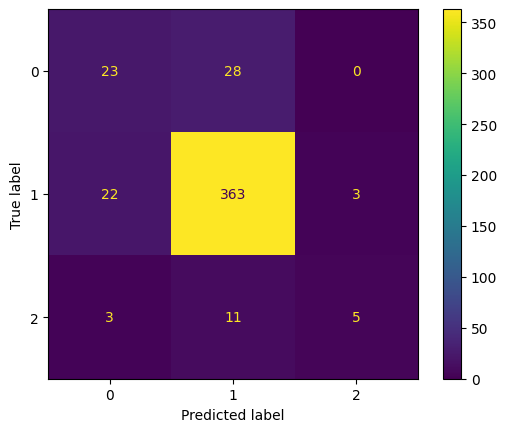

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

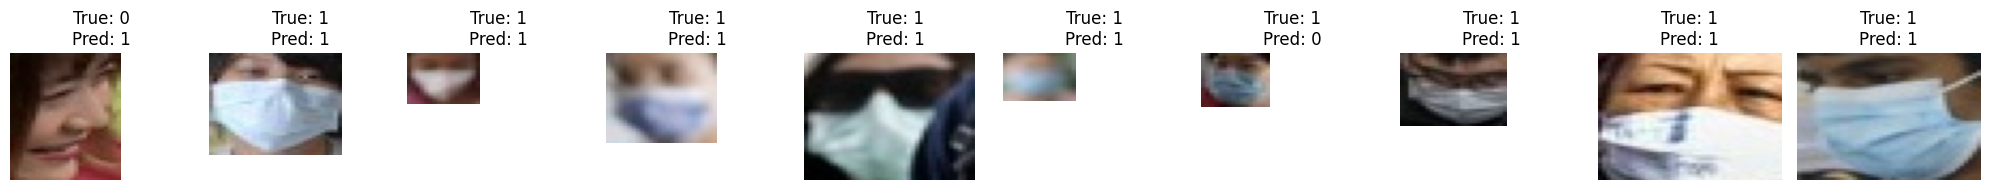

In [ ]:
from sklearn.utils import shuffle
#shuffle the images everytime I run this cell
X_test_shuffled, y_test_shuffled, y_pred_shuffled = shuffle(X_test, y_test, y_pred, random_state=None)

# Number of images to display
num_images = 10

# Create the plot
fig, axes = plt.subplots(1, num_images, figsize=(20, 2), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    # Display the original image
    ax.imshow(X_test_shuffled[i], cmap='gray', aspect='auto')  # 'aspect=auto' lets the image retain its original aspect ratio
    # Set the title with the true label and predicted label
    ax.set_title(f'True: {y_test_shuffled[i]}\nPred: {y_pred_shuffled[i]}')
    ax.axis('off')  # Turn off axis markers and labels

plt.tight_layout()
plt.show()